### The objective is to test some images and see the metric results

## Imports

In [1]:
## Imports

from src.dataset.PatchImageTool import PatchImageTool
from src.utils.PytorchUtil import PytorchUtil as torchUtil
from src.utils.PlotUtils import PlotUtils

import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import skimage.metrics as metrics
import platform  # Import the platform module to detect the OS
import cv2
import math

import platform
import os

device = None
if platform.system() == 'Windows':  # Check if the OS is Windows
    import torch_directml  # Import torch_directml only on Windows
    device = torch_directml.device()

force_cpu = True

if not device:
    if torch.cuda.is_available() and not force_cpu:
        device = torch.device('cuda')
        torch.cuda.empty_cache()
    else:
        device = torch.device('cpu')

print(device)

cpu


## Define the model

In [2]:
from src.models.InitModel import InitModel

UPSCALE_FACTOR = 2

PATCH_SIZE = 256
PATCH_RESIZE_SIZE = PATCH_SIZE // UPSCALE_FACTOR

LEARNING_RATE = 1e-4
BATCH_SIZE = 256
USE_PREDICTION_BY_PATCH = False 

DO_DOWNSCALE_IMAGE_BY_FACTOR = False
DO_PATCH_DISPLAY = False

CHANNELS = ["b", "g", "r"]
CHANNELS_POSITION = {"b": 0, "g": 1, "r": 2, "d": 3, "s": 4}
CHANNELS_DOWN_RESOLUTION = {
    "b" : "area", "g" : "area", "r" : "area", "d" : "bicubic", "s" : "bicubic"
}
CHANNELS_INTERPOLATION_METHODS = [
    "bicubic", "bicubic", "bicubic"
]

SEED = None

IMAGE = "john.png"

PATH = "results/weights-upscale-residual-lpips-v.2"
NAME = PATH


2024-01-27 23:30:26.358565: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-27 23:30:26.389889: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-27 23:30:26.389922: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-27 23:30:26.389942: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-27 23:30:26.396117: I tensorflow/core/platform/cpu_feature_g

In [3]:
if not os.path.exists(PATH):
    raise Exception("Model not found")

if not os.path.exists("resources/" + IMAGE):
    raise Exception("Image not found")

In [4]:
exp = InitModel.create_model_static(NAME, PATH, 
                                    {
                                        "learningRate": LEARNING_RATE, 
                                        "channel_positions" : CHANNELS,
                                        "channel_interpolations" : CHANNELS_INTERPOLATION_METHODS,
                                    }, UPSCALE_FACTOR, device)

if SEED:
    torch.manual_seed(SEED)
    np.random.seed(SEED)

## Load image and test

In [5]:
import torchvision.transforms as transforms

image_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

In [6]:
resources_path = "resources"

hr_data_path = os.path.join(resources_path, IMAGE)

hr_data_np = torchUtil.open_data(hr_data_path)
#hr_data_np = torchUtil.norm_numpy_image(hr_data_np)

hr_img_size = (hr_data_np.shape[1], hr_data_np.shape[0])

# apply transform to image
hr_data_tensor = image_transform(hr_data_np).to(device)

hr_img_tensor = torchUtil.filter_data_to_img(hr_data_tensor, CHANNELS_POSITION, {"b", "g", "r"})
hr_img_np = torchUtil.tensor_to_numpy(hr_img_tensor)

# divide image image by x
if DO_DOWNSCALE_IMAGE_BY_FACTOR:
    resized_data_np = torchUtil.shrink_data(hr_data_np, (hr_img_size[0] // UPSCALE_FACTOR, hr_img_size[1] // UPSCALE_FACTOR), 
                                            CHANNELS, CHANNELS_POSITION, 
                                            channel_downresolution_methods=CHANNELS_DOWN_RESOLUTION)
else:
    # copy
    resized_data_np = hr_data_np.copy()

resized_data_tensor = image_transform(resized_data_np).to(device)
resized_img_tensor = torchUtil.filter_data_to_img(resized_data_tensor, CHANNELS_POSITION, {"b", "g", "r"})

resized_img_np = torchUtil.tensor_to_numpy(resized_img_tensor)
resized_img_size = (resized_img_np.shape[0], resized_img_np.shape[1])

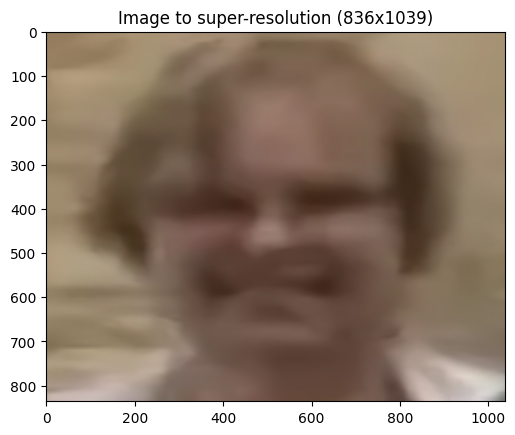

In [12]:
if DO_DOWNSCALE_IMAGE_BY_FACTOR:
    PlotUtils.show_high_low_res_images([resized_img_tensor], [hr_img_tensor], upscale_factor_list=[UPSCALE_FACTOR], plot_title="Example")
else: 
    plt.imshow(torchUtil.numpy_to_image(resized_img_np))
    plt.title(f"Image to super-resolution ({resized_img_size[0]}x{resized_img_size[1]})")
    plt.show()

In [8]:
if DO_PATCH_DISPLAY:
    num_patch_width = math.ceil(resized_img_size[0] / PATCH_RESIZE_SIZE)
    num_patch_height = math.ceil(resized_img_size[1] / PATCH_RESIZE_SIZE)

    num_patch_total = num_patch_width * num_patch_height

    resized_data_patch_tensors = PatchImageTool.get_patchs_from_image(resized_data_tensor, patch_size=PATCH_RESIZE_SIZE)

    resized_img_patch_tensors = []
    for patch in resized_data_patch_tensors:
        resized_img_patch_tensors.append(torchUtil.filter_data_to_img(patch, CHANNELS_POSITION, {"b", "g", "r"}))

In [9]:
if DO_PATCH_DISPLAY:
        num_cols = min(5, num_patch_width)
        num_rows = min(5, num_patch_height)

        # Show some image patches
        fig, ax = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))
        for i in range(num_rows):
            for j in range(num_cols):
                # ndarray
                
                ax[i, j].imshow(torchUtil.tensor_to_image(resized_img_patch_tensors[i * num_patch_width + j]))
                ax[i, j].set_title(f"Patch {i * num_patch_width + j}")
                ax[i, j].axis('off')

In [10]:
if DO_PATCH_DISPLAY:
    # Make the model predict one patch
    patch_index = 0

    resized_data_patch_tensor = resized_data_patch_tensors[patch_index].to(device)
    resized_img_patch_tensor = resized_img_patch_tensors[patch_index]
    print("Patch tensor size", resized_data_patch_tensor.shape, "type", resized_data_patch_tensor.dtype)

    with torch.no_grad():
        pred_img_tensors = exp.net(resized_data_patch_tensor)
        pred_img_tensor = pred_img_tensors.squeeze(0)
        """prediction = exp.net(prediction)
        prediction = prediction.squeeze(0)"""

        pred_img_np = torchUtil.tensor_to_numpy(pred_img_tensor)

        print("Prediction tensor size", pred_img_np.shape, "type", pred_img_np.dtype)

        bicubic_img_np = torchUtil.resize_tensor_to_numpy(resized_img_patch_tensor, (PATCH_SIZE, PATCH_SIZE))

        subtraction_img_np = torchUtil.norm_numpy_image(pred_img_np - bicubic_img_np)

    fig, ax = plt.subplots(1, 4, figsize=(15, 15))
    ax[0].imshow(torchUtil.tensor_to_image(resized_img_patch_tensor))
    ax[0].set_title(f"Low res patch")

    ax[1].imshow(torchUtil.numpy_to_image(pred_img_np))
    ax[1].set_title(f"Prediction")

    ax[2].imshow(torchUtil.numpy_to_image(bicubic_img_np))
    ax[2].set_title(f"Bicubic")

    ax[3].imshow(torchUtil.numpy_to_image(subtraction_img_np))
    ax[3].set_title(f"Subtraction")

    plt.show()

In [11]:
pred_img_torch = None

if USE_PREDICTION_BY_PATCH:
    pred_img_torch = PatchImageTool.predict_image_from_image_patches(
                        exp, hr_img_size, resized_data_patch_tensors, 
                        device, 
                        patch_size=PATCH_RESIZE_SIZE, upscale_factor=UPSCALE_FACTOR)
    print("Used prediction by patch")
else :
    pred_img_torch = exp.net(resized_data_tensor.unsqueeze(0)).squeeze(0)    
    print("Used prediction by image")

image_to_show = torchUtil.numpy_to_image(hr_img_np)

pred_img_np = torchUtil.tensor_to_numpy(pred_img_torch)
pred_img = torchUtil.numpy_to_image(pred_img_np)


if DO_DOWNSCALE_IMAGE_BY_FACTOR:
    bicubic_img_np = torchUtil.resize_tensor_to_numpy(resized_img_tensor, (hr_img_size[1], hr_img_size[0]))
    bicubic_img = torchUtil.numpy_to_image(bicubic_img_np)

    substract_img_np = torchUtil.norm_numpy_image(bicubic_img_np - pred_img_np)
    substract_img = torchUtil.numpy_to_image(substract_img_np)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1039 but got size 1038 for tensor number 1 in the list.

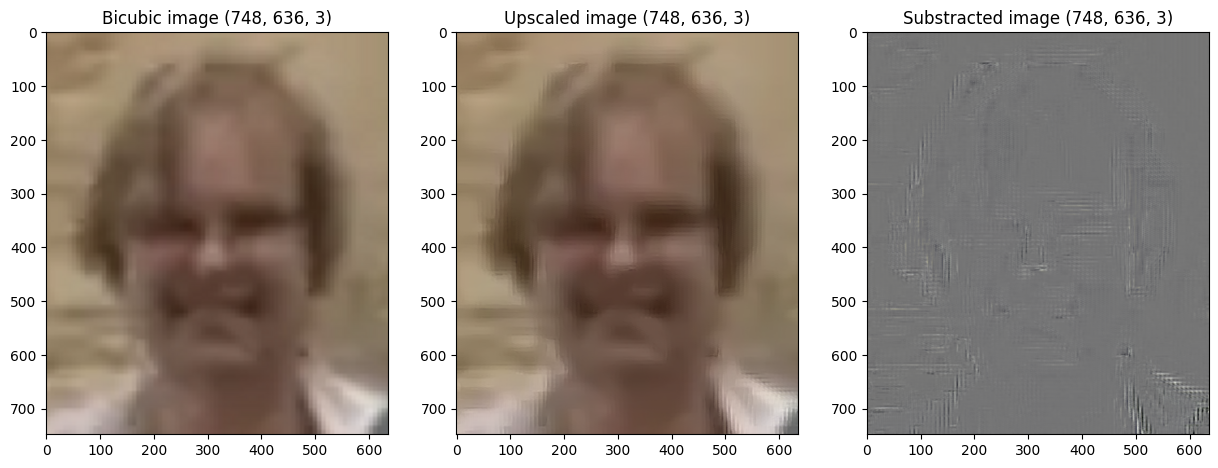

In [ ]:
if DO_DOWNSCALE_IMAGE_BY_FACTOR:
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(bicubic_img)
    ax[0].set_title(f"Bicubic image {bicubic_img.shape}")

    ax[1].imshow(pred_img)
    ax[1].set_title(f"Upscaled image {pred_img.shape}")

    ax[2].imshow(substract_img, vmin=substract_img_np.min(), vmax=substract_img_np.max())
    ax[2].set_title(f"Substracted image {substract_img.shape}")

else:
    # Show original and predicted image
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))
    ax[0].imshow(image_to_show)
    ax[0].set_title(f"Original image {image_to_show.shape}")
    
    ax[1].imshow(pred_img)
    ax[1].set_title(f"Upscaled image {pred_img.shape}")

plt.show()

In [ ]:
if DO_DOWNSCALE_IMAGE_BY_FACTOR:
    # Compute PSNR and SSIM
    psnr = metrics.peak_signal_noise_ratio(hr_img_np, pred_img_np, data_range=1)
    ssim = metrics.structural_similarity(hr_img_np, pred_img_np, \
                                        win_size=7, data_range=1, multichannel=True, channel_axis=2)

    print(f"Model PSNR: {psnr} SSIM: {ssim}")

    bicubic_psnr = metrics.peak_signal_noise_ratio(hr_img_np, bicubic_img_np, data_range=1)
    bicubic_ssim = metrics.structural_similarity(hr_img_np, bicubic_img_np, \
                                        win_size=7, data_range=1, multichannel=True, channel_axis=2)

    print(f"Bicubic PSNR: {bicubic_psnr} SSIM: {bicubic_ssim}")

Model PSNR: 40.29355705601287 SSIM: 0.9517910480499268
Bicubic PSNR: 43.701756535193894 SSIM: 0.9714908003807068


In [ ]:
# Saving the image results

output_path = "results/examples/"

if not os.path.exists(output_path):
    os.makedirs(output_path)

# empty the output folder

for filename in os.listdir(output_path):
    file_path = os.path.join(output_path, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

if not os.path.exists(output_path):
    os.makedirs(output_path)

# Save the original image
cv2.imwrite(os.path.join(output_path, "original.png"), (hr_img_np * 255.0).astype(np.uint8))
# Save the upscaled image
cv2.imwrite(os.path.join(output_path, "upscaled.png"), (pred_img_np * 255.0).astype(np.uint8))

if DO_DOWNSCALE_IMAGE_BY_FACTOR:
    # Save the bilinear image
    cv2.imwrite(os.path.join(output_path, "bicubic.png"), (bicubic_img_np * 255.0).astype(np.uint8))
    # Save the substracted image
    cv2.imwrite(os.path.join(output_path, "substracted.png"), (torchUtil.numpy_to_image(substract_img_np) * 255.0).astype(np.uint8))
